In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import nibabel as nib
from torch.utils.data import DataLoader
from torchvision import transforms
from scipy.ndimage import *
import skimage

from src.visualization import plot_batch
from src.data import KmaderDataset, unpack_batch
from src.data.preprocess import *

In [3]:
img = nib.load("data/raw/kmader/3d_images/IMG_0002.nii.gz")
img = img.get_fdata()
img = np.clip(img, -512, 512)
img -= img.min()  # shift to range (0, inf)
img /= img.max()  # normalize
masks = nib.load("data/raw/kmader/3d_images/MASK_0002.nii.gz")
masks = np.array(masks.dataobj, dtype=np.int64)
img.shape, masks.shape

((325, 512, 512), (325, 512, 512))

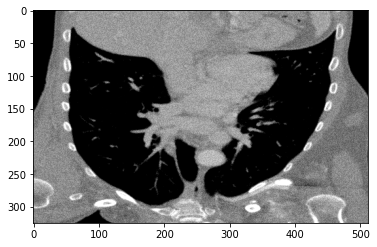

In [4]:
plt.imshow(img[:, 256, :], cmap='gray')

array([0, 1])

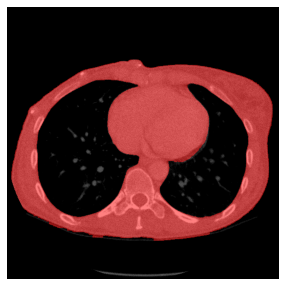

In [4]:
im = img[100]
mask_lungs = masks[100]
mask_lungs[mask_lungs > 0] = 1
mask_around_lungs = (im > im.min()).astype(np.int64)
mask_around_lungs = binary_opening(mask_around_lungs, structure=np.ones((15, 15)), 
                                    iterations=1).astype(np.int64)

mask_body = mask_around_lungs + mask_lungs
mask_body[mask_body > 0] = 1
mask_body = binary_fill_holes(mask_body, structure=np.ones((5, 5)))
mask_body = mask_body.astype(np.int64)
mask_around_lungs = mask_body - mask_lungs

plot_batch(np.expand_dims(im, axis=0),
           np.expand_dims(mask_around_lungs, axis=0), 
           nrows=1, ncols=1, figsize=(5,5), mask_alpha=0.5)
np.unique(mask_around_lungs)

array([0, 1])

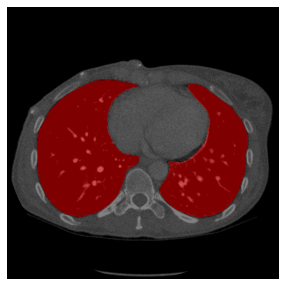

In [11]:
restored_mask_body = binary_fill_holes(mask_around_lungs).astype(np.int64)
restored_mask_lungs = restored_mask_body - mask_around_lungs
plot_batch(np.expand_dims(im, axis=0),
           np.expand_dims(restored_mask_lungs, axis=0), 
           nrows=1, ncols=1, figsize=(5,5), mask_alpha=0.5)
np.unique(restored_mask_body)

In [84]:
transform = transforms.Compose([
    Clip(-512, 512),
    ExtractMaskAroundLungs(),
    ToTensor(),
    Normalize(0, 1),
])
ds = KmaderDataset("data/raw/kmader/3d_images/",
                   ct_ids=["0002"],
                   transform=transform)
loader = DataLoader(ds, batch_size=16, shuffle=True)

Loading CT scans: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


In [91]:
from torch.utils.data import random_split
train_ratio = 0.8
num_train = int(train_ratio * len(ds))
num_val = len(ds) - num_train
train_ds, val_ds = random_split(ds, [num_train, num_val],
                                generator=torch.Generator().manual_seed(25))


In [90]:
random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))

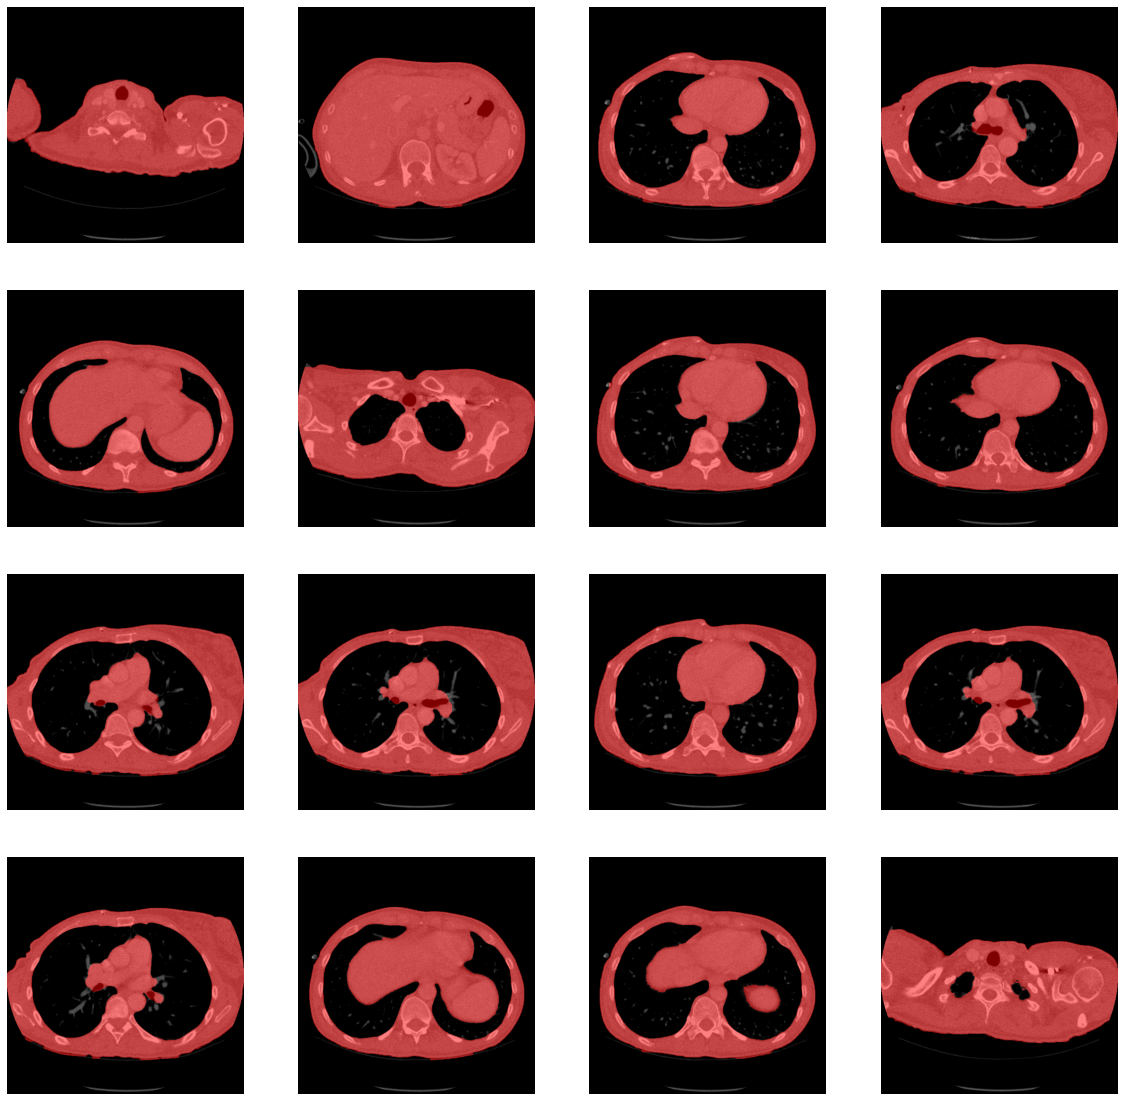

In [87]:
sample = next(iter(loader))
plot_batch(sample["img"], sample["mask"], nrows=4, ncols=4, mask_alpha=0.5,
          figsize=(20,20))

In [12]:
train_ds = KmaderDataset(
    "data/raw/kmader/3d_images/",
    ct_ids=["0002", "0031", "0059"],
    transform=transform,
)
val_ds = KmaderDataset(
    "data/raw/kmader/3d_images/", ct_ids=["0078"], transform=transform
)
len(train_ds), len(val_ds)

Loading CT scans: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


(1091, 117)

In [ ]:
luna_dir = "data/raw/kmader
im = Image.open(f"{luna_dir}/2d_images/ID_0000_Z_0142.tif")
raw_img = np.array(im, dtype=np.float)
img = raw_img.copy()
img = img - img.min()
img /= img.max()
plt.imshow(img, cmap='gray')

In [54]:
Data_train  = np.load("/home/ducpm/BCDU-Net/Lung Segmentation/processed_data/data_train.npy")
Mask_train  = np.load("/home/ducpm/BCDU-Net/Lung Segmentation/processed_data/mask_train.npy")
Maska_train = np.load("/home/ducpm/BCDU-Net/Lung Segmentation/processed_data/Train_maska.npy")
FOV_train   = np.load("/home/ducpm/BCDU-Net/Lung Segmentation/processed_data/FOV_tr.npy")
                      
#np.save(folder+'data_train' , Train_img)
#np.save(folder+'data_test'  , Test_img)
#np.save(folder+'mask_train' , Train_mask)
#np.save(folder+'mask_test'  , Test_mask)
#
#np.save(folder+'Train_maska' , Train_maska)
#np.save(folder+'Test_maska'  , Test_maska)
#np.save(folder+'FOV_tr'      , FOV_tr)
#np.save(folder+'FOV_te'      , FOV_te)
#

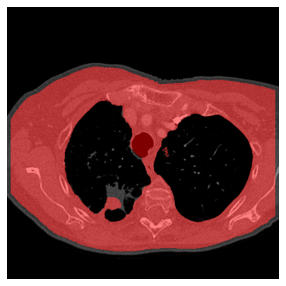

In [62]:
# NICE FUCKING preprocessing dude
plot_batch(np.expand_dims(Data_train[200], axis=0),
           np.expand_dims(Maska_train[200], axis=0), 
           nrows=1, ncols=1, figsize=(5,5), mask_alpha=0.5)

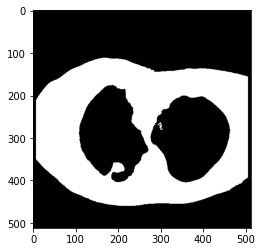

In [56]:
plt.imshow(Maska_train[200], cmap='gray')

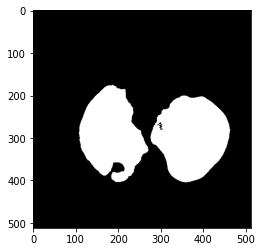

In [23]:
plt.imshow(Mask_train[200], cmap='gray')

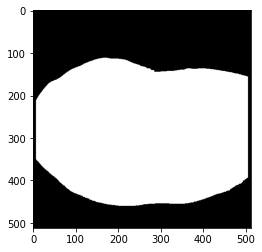

In [17]:
plt.imshow(FOV_train[200], cmap='gray')

In [ ]:
plot_batch(Train_img[50:66], Train_maska[50:66] / 255., nrows=4, ncols=4)

In [ ]:
alpha = np.int16(np.floor(Data_train.shape[0]* 0.7))
en_d  = Data_train.shape[0]

Train_img      = Data_train[0:alpha,:,:]
Test_img       = Data_train[alpha:en_d,:,:]

Train_mask     = Mask_train[0:alpha,:,:]
Test_mask      = Mask_train[alpha:en_d,:,:]

Train_maska     = Maska_train[0:alpha,:,:]
Test_maska      = Maska_train[alpha:en_d,:,:]

FOV_tr     = FOV_train[0:alpha,:,:]
FOV_te      = FOV_train[alpha:en_d,:,:]

In [33]:
ds[0]

{'img': array([[-907., -802., -886., ..., -848., -824., -855.],
        [-882., -821., -761., ..., -847., -777., -909.],
        [-846., -748., -747., ..., -837., -792., -891.],
        ...,
        [-893., -840., -918., ..., -793., -805., -739.],
        [-796., -903., -718., ..., -776., -737., -722.],
        [-717., -833., -897., ..., -775., -878., -908.]]),
 'mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [45]:
from pathlib import Path
a = list(Path("data/raw/kmader/3d_images/").glob("IMG*"))
str(a[0]).replace("IMG","MASK")
a

[PosixPath('data/raw/kmader/3d_images/IMG_0002.nii.gz'),
 PosixPath('data/raw/kmader/3d_images/IMG_0031.nii.gz'),
 PosixPath('data/raw/kmader/3d_images/IMG_0078.nii.gz')]